In [1]:
import pandas as pd
import numpy as np

import os
import glob

import re

import os
import glob
import pandas as pd
import missingno as msno
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", 100)
pd.set_option("display.max_rows", None)

# **1. Data Preparation**

## **1.1 Data Understanding**

Ini adalah dataset publik e-commerce Brasil dari pesanan yang dibuat di Olist Store. Dataset ini memiliki informasi dari 100 ribu pesanan dari tahun 2016 hingga 2018 yang dibuat di beberapa pasar di Brasil. Fitur-fiturnya memungkinkan untuk melihat pesanan dari berbagai dimensi: mulai dari status pesanan, harga, pembayaran, dan kinerja pengiriman hingga lokasi pelanggan, atribut produk, dan akhirnya ulasan yang ditulis oleh pelanggan. Selain itu ada juga dataset geolokasi yang menghubungkan kode pos Brasil dengan koordinat bujur/lintang.

### **1.1.1 Data Schema**

Data dibagi dalam beberapa dataset. Skema data bisa dilihat pada gambar berikut:
<p> <p>
<figure>
  <center><img src = "https://raw.githubusercontent.com/aridiawan/ecommerce-analysis/main/data/raw/ERD.jpg" alt ="Scheme Data Table" width = 900; height = 647></center>
  <figcaption align = "center">Gambar 1. <em>Scheme Data</em> </figcaption>
</figure>
<p> <p>

Fitur atau kolom yang menjadi penghubung antar dataset (primary key dan foreign key) adalah:
* customer_id
* order_id
* product_id
* product_category_name
* seller_id
* customer_zip_code_prefix
* seller_zip_code_prefix
* geolocation_zip_code_prefix

### **1.1.2 Feature Description**

Berikut adalah fitur-fitur yang tersedia dalam dataset:
<p> <p>
<figure>
  <center><img src = "https://raw.githubusercontent.com/aridiawan/ecommerce-analysis/main/data/raw/Olist-Dataset-Description.jpg" alt ="Scheme Data Table" width = 900; height = 1056></center>
  <figcaption align = "center">Gambar 2. <em>Deskripsi Feature</em> </figcaption>
</figure>
<p> <p>

### **1.1.3 Data Skimming**

In [2]:
# load data
RAW_DATA_DIR = r"..\data\raw"
file_list = glob.glob(RAW_DATA_DIR + "\*.csv")

In [3]:
# function text handling
def efn(text):
    file = text.split('\\')[-1].replace('.csv','')
    return file

def white_string_to_nan(data):
    return data.replace(r'^\s*$', np.nan, regex=True)

In [4]:
# create dictionary of dataset
dfs = {f'{efn(file)}': white_string_to_nan(pd.read_csv(file, engine="pyarrow")) for file in file_list}

In [5]:
# check data info
dataInfo = []

for n in dfs.keys():
    dataInfo.append({
        'dataset_name' : n,
        'shape' : dfs[n].shape,
        'columns' : list(dfs[n].columns),
        'duplicate' : dfs[n].duplicated().sum(),
        'null' : dfs[n].isna().sum().sum(),
        'null_columns' : dfs[n].columns[dfs[n].isna().any()].tolist()
    })

pd.DataFrame(dataInfo)

,dataset_name,shape,columns,duplicate,null,null_columns
0,olist_customers_dataset,"(99441, 5)","[customer_id, customer_unique_id, customer_zip_code_prefix, customer_city, customer_state]",0,0,[]
1,olist_geolocation_dataset,"(1000163, 5)","[geolocation_zip_code_prefix, geolocation_lat, geolocation_lng, geolocation_city, geolocation_st...",261831,0,[]
2,olist_orders_dataset,"(99441, 8)","[order_id, customer_id, order_status, order_purchase_timestamp, order_approved_at, order_deliver...",0,4908,"[order_approved_at, order_delivered_carrier_date, order_delivered_customer_date]"
3,olist_order_items_dataset,"(112650, 7)","[order_id, order_item_id, product_id, seller_id, shipping_limit_date, price, freight_value]",0,0,[]
4,olist_order_payments_dataset,"(103886, 5)","[order_id, payment_sequential, payment_type, payment_installments, payment_value]",0,0,[]
5,olist_order_reviews_dataset,"(99224, 7)","[review_id, order_id, review_score, review_comment_title, review_comment_message, review_creatio...",0,145932,"[review_comment_title, review_comment_message]"
6,olist_products_dataset,"(32951, 9)","[product_id, product_category_name, product_name_lenght, product_description_lenght, product_pho...",0,2448,"[product_category_name, product_name_lenght, product_description_lenght, product_photos_qty, pro..."
7,olist_sellers_dataset,"(3095, 4)","[seller_id, seller_zip_code_prefix, seller_city, seller_state]",0,0,[]
8,product_category_name_translation,"(71, 2)","[product_category_name, product_category_name_english]",0,0,[]


#### **Insights**
* Terdapat duplikasi data berdasarkan seluruh kolom di **olist_geolocation_dataset**
* Terdapat missing values di tiga dataset yaitu:
    * **olist_orders_dataset**
    * **olist_order_reviews**
    * **olist_products_dataset**

In [6]:
# skimming function
def skim(data, name):
    summary = pd.DataFrame({
                'dataset' : name,
                'column': data.columns.values,
                'type': data.dtypes.values,
                'unique': data.nunique().values,
                'null': data.isna().sum().reset_index()[0],
                'null_pct': round(data.isna().sum().reset_index()[0]/len(data)*100, 2),
                'min': data.dropna().min().values,
                'max': data.dropna().max().values,
                'sample_unique': [data[col].unique() for col in data.columns.values]
                })
    return summary

# check
pd.concat([skim(dfs[n], n) for n in dfs.keys()], sort=False, ignore_index=True)

,dataset,column,type,unique,null,null_pct,min,max,sample_unique
0,olist_customers_dataset,customer_id,object,99441,0,0.00,00012a2ce6f8dcda20d059ce98491703,ffffe8b65bbe3087b653a978c870db99,"[06b8999e2fba1a1fbc88172c00ba8bc7, 18955e83d337fd6b2def6b18a428ac77, 4e7b3e00288586ebd08712fdd03..."
1,olist_customers_dataset,customer_unique_id,object,96096,0,0.00,0000366f3b9a7992bf8c76cfdf3221e2,ffffd2657e2aad2907e67c3e9daecbeb,"[861eff4711a542e4b93843c6dd7febb0, 290c77bc529b7ac935b93aa66c333dc3, 060e732b5b29e8181a18229c7b0..."
2,olist_customers_dataset,customer_zip_code_prefix,int64,14994,0,0.00,1003,99990,"[14409, 9790, 1151, 8775, 13056, 89254, 4534, 35182, 81560, 30575, 39400, 20231, 18682, 5704, 95..."
3,olist_customers_dataset,customer_city,object,4119,0,0.00,abadia dos dourados,zortea,"[franca, sao bernardo do campo, sao paulo, mogi das cruzes, campinas, jaragua do sul, timoteo, c..."
4,olist_customers_dataset,customer_state,object,27,0,0.00,AC,TO,"[SP, SC, MG, PR, RJ, RS, PA, GO, ES, BA, MA, MS, CE, DF, RN, PE, MT, AM, AP, AL, RO, PB, TO, PI,..."
5,olist_geolocation_dataset,geolocation_zip_code_prefix,int64,19015,0,0.00,1001,99990,"[1037, 1046, 1041, 1035, 1012, 1047, 1013, 1029, 1011, 1032, 1014, 1039, 1024, 1009, 1020, 1043,..."
6,olist_geolocation_dataset,geolocation_lat,float64,717372,0,0.00,-36.605374,45.065933,"[-23.54562128115268, -23.546081127035535, -23.54612896641469, -23.5443921648681, -23.54157796171..."
7,olist_geolocation_dataset,geolocation_lng,float64,717615,0,0.00,-101.466766,121.105394,"[-46.63929204800168, -46.64482029837157, -46.64295148361138, -46.63949930627844, -46.64160722329..."
8,olist_geolocation_dataset,geolocation_city,object,8011,0,0.00,* cidade,óleo,"[sao paulo, são paulo, sao bernardo do campo, jundiaí, taboão da serra, sãopaulo, sp, sa£o paulo..."
9,olist_geolocation_dataset,geolocation_state,object,27,0,0.00,AC,TO,"[SP, RN, AC, RJ, ES, MG, BA, SE, PE, AL, PB, CE, PI, MA, PA, AP, AM, RR, DF, GO, RO, TO, MT, MS,..."


#### **Insights**
* Detail missing values:
    * **olist_orders_dataset** terjadi pada kolom: **order_approved_at, order_delivered_carrier_date, order_delivered_customer_date**
    * **olist_order_payments_dataset** terjadi pada kolom: **payment_type** (terdapat kategori not_defined)
    * **olist_order_reviews_dataset** terjadi pada kolom: **review_message_title, review_message_comment**
    * **olist_products_dataset** terjadi pada kolom: **product_category_name, product_name_lenght, product_description_lenght, product_photos_qty, product_weight_g, product_length_cm, product_height_cm, product_width_cm**
* Kolom **review_message_title, review_message_comment, product_name_lenght, product_description_lenght, product_photos_qty, product_weight_g, product_length_cm, product_height_cm, product_width_cm** tidak digunakan dalam analisis sehingga kolom ini tidak akan ikut dimerge
* Handling missing values akan dilakukan setelah merging dataset
* Kolom **product_category_name** mempunyai jumlah unique value yang berbeda pada **olist_products_dataset** (73) dan **product_category_name_translation** (71)
* **olist_geolocation_dataset** dan **olist_seller_dataset** tidak akan digunakan dalam analisis

In [7]:
pd.reset_option('display.max_colwidth')
pd.reset_option('display.max_rows')

#### **olist_customers_dataset**

In [8]:
customers = dfs["olist_customers_dataset"]
customers[customers.duplicated(subset=["customer_unique_id"], keep=False)].sort_values(by=["customer_unique_id"], ignore_index=True).head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,24b0e2bd287e47d54d193e7bbb51103f,00172711b30d52eea8b313a7f2cced02,45200,jequie,BA
1,1afe8a9c67eec3516c09a8bdcc539090,00172711b30d52eea8b313a7f2cced02,45200,jequie,BA
2,1b4a75b3478138e99902678254b260f4,004288347e5e88a27ded2bb23747066c,26220,nova iguacu,RJ
3,f6efe5d5c7b85e12355f9d5c3db46da2,004288347e5e88a27ded2bb23747066c,26220,nova iguacu,RJ
4,49cf243e0d353cd418ca77868e24a670,004b45ec5c64187465168251cd1c9c2f,57055,maceio,AL


#### **olist_orders_dataset_df**

In [9]:
orders = dfs["olist_orders_dataset"]
orders["order_status"].value_counts(normalize=True).reset_index()

,order_status,proportion
0,delivered,0.970203
1,shipped,0.011132
2,canceled,0.006285
3,unavailable,0.006124
4,invoiced,0.003158
5,processing,0.003027
6,created,0.000050
7,approved,0.000020


#### **olist_order_items_dataset**

In [10]:
order_items = dfs["olist_order_items_dataset"]
order_items[order_items.duplicated(subset=["order_id"], keep=False)].sort_values(by=["order_id", "order_item_id"], ignore_index=True).head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,0008288aa423d2a3f00fcb17cd7d8719,1,368c6c730842d78016ad823897a372db,1f50f920176fa81dab994f9023523100,2018-02-21 02:55:52,49.90,13.37
1,0008288aa423d2a3f00fcb17cd7d8719,2,368c6c730842d78016ad823897a372db,1f50f920176fa81dab994f9023523100,2018-02-21 02:55:52,49.90,13.37
2,00143d0f86d6fbd9f9b38ab440ac16f5,1,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.10
3,00143d0f86d6fbd9f9b38ab440ac16f5,2,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.10
4,00143d0f86d6fbd9f9b38ab440ac16f5,3,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.10


In [11]:
order_items[order_items["freight_value"]==0].head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
114,00404fa7a687c8c44ca69d42695aae73,1,53b36df67ebb7c41585e8d54d6772e08,7d13fca15225358621be4086e1eb0964,2018-05-15 04:31:26,99.9,0.0
258,00a870c6c06346e85335524935c600c0,1,aca2eb7d00ea1a7b8ebd4e68314663af,955fee9216a65b617aa5c0531780ce60,2018-05-14 00:14:29,69.9,0.0
483,011c899816ea29773525bd3322dbb6aa,1,53b36df67ebb7c41585e8d54d6772e08,7d13fca15225358621be4086e1eb0964,2018-05-07 05:30:45,99.9,0.0
508,012b3f6ab7776a8ab3443a4ad7bef2e6,1,422879e10f46682990de24d770e7f83d,1f50f920176fa81dab994f9023523100,2018-05-09 21:30:50,53.9,0.0
509,012b3f6ab7776a8ab3443a4ad7bef2e6,2,422879e10f46682990de24d770e7f83d,1f50f920176fa81dab994f9023523100,2018-05-09 21:30:50,53.9,0.0


#### **olist_order_payments_dataset**

In [12]:
order_payments = dfs["olist_order_payments_dataset"]
order_payments[order_payments.duplicated(subset=["order_id"], keep=False)].sort_values(by=["order_id", "payment_sequential"], ignore_index=True).head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,0016dfedd97fc2950e388d2971d718c7,1,credit_card,5,52.63
1,0016dfedd97fc2950e388d2971d718c7,2,voucher,1,17.92
2,002f19a65a2ddd70a090297872e6d64e,1,voucher,1,44.11
3,002f19a65a2ddd70a090297872e6d64e,2,voucher,1,33.18
4,0071ee2429bc1efdc43aa3e073a5290e,1,voucher,1,100.00


In [13]:
order_payments[order_payments["payment_installments"]==0]

,order_id,payment_sequential,payment_type,payment_installments,payment_value
46982,744bade1fcf9ff3f31d860ace076d422,2,credit_card,0,58.69
79014,1a57108394169c0b47d8f876acc9ba2d,2,credit_card,0,129.94


In [14]:
order_payments[order_payments["payment_value"]==0]

,order_id,payment_sequential,payment_type,payment_installments,payment_value
19922,8bcbe01d44d147f901cd3192671144db,4,voucher,1,0.0
36822,fa65dad1b0e818e3ccc5cb0e39231352,14,voucher,1,0.0
43744,6ccb433e00daae1283ccc956189c82ae,4,voucher,1,0.0
51280,4637ca194b6387e2d538dc89b124b0ee,1,not_defined,1,0.0
57411,00b1cb0320190ca0daa2c88b35206009,1,not_defined,1,0.0
62674,45ed6e85398a87c253db47c2d9f48216,3,voucher,1,0.0
77885,fa65dad1b0e818e3ccc5cb0e39231352,13,voucher,1,0.0
94427,c8c528189310eaa44a745b8d9d26908b,1,not_defined,1,0.0
100766,b23878b3e8eb4d25a158f57d96331b18,4,voucher,1,0.0


#### **olist_order_reviews_dataset**

In [15]:
order_reviews = dfs["olist_order_reviews_dataset"]
order_reviews[order_reviews.duplicated(subset=["review_id"], keep=False)].sort_values(by=["review_id"]).head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
46678,00130cbe1f9d422698c812ed8ded1919,dfcdfc43867d1c1381bfaf62d6b9c195,1,NaN,"O cartucho ""original HP"" 60XL não é reconhecid...",2018-03-07,2018-03-20 18:08:23
29841,00130cbe1f9d422698c812ed8ded1919,04a28263e085d399c97ae49e0b477efa,1,NaN,"O cartucho ""original HP"" 60XL não é reconhecid...",2018-03-07,2018-03-20 18:08:23
90677,0115633a9c298b6a98bcbe4eee75345f,78a4201f58af3463bdab842eea4bc801,5,NaN,NaN,2017-09-21,2017-09-26 03:27:47
63193,0115633a9c298b6a98bcbe4eee75345f,0c9850b2c179c1ef60d2855e2751d1fa,5,NaN,NaN,2017-09-21,2017-09-26 03:27:47
92876,0174caf0ee5964646040cd94e15ac95e,f93a732712407c02dce5dd5088d0f47b,1,NaN,Produto entregue dentro de embalagem do fornec...,2018-03-07,2018-03-08 03:00:53


In [16]:
order_reviews[order_reviews.duplicated(subset=["order_id"], keep=False)].sort_values(by=["order_id"]).head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
25612,89a02c45c340aeeb1354a24e7d4b2c1e,0035246a40f520710769010f752e7507,5,NaN,NaN,2017-08-29,2017-08-30 01:59:12
22423,2a74b0559eb58fc1ff842ecc999594cb,0035246a40f520710769010f752e7507,5,NaN,Estou acostumada a comprar produtos pelo barat...,2017-08-25,2017-08-29 21:45:57
22779,ab30810c29da5da8045216f0f62652a2,013056cfe49763c6f66bda03396c5ee3,5,NaN,NaN,2018-02-22,2018-02-23 12:12:30
68633,73413b847f63e02bc752b364f6d05ee9,013056cfe49763c6f66bda03396c5ee3,4,NaN,NaN,2018-03-04,2018-03-05 17:02:00
854,830636803620cdf8b6ffaf1b2f6e92b2,0176a6846bcb3b0d3aa3116a9a768597,5,NaN,NaN,2017-12-30,2018-01-02 10:54:06


#### **olist_products_dataset**

In [17]:
products = dfs["olist_products_dataset"]
[category for category in products.dropna()["product_category_name"].unique() if '_2' in category]

['eletrodomesticos_2', 'casa_conforto_2']

#### **product_category_name_translation**

In [18]:
category_translation = dfs["product_category_name_translation"]
set(set(products["product_category_name"].dropna())).difference(category_translation["product_category_name"])

{'pc_gamer', 'portateis_cozinha_e_preparadores_de_alimentos'}

In [19]:
[category for category in category_translation.dropna()["product_category_name"].unique() if '_2' in category]

['eletrodomesticos_2', 'casa_conforto_2']

#### **Insights Summary**
* **olist_customers_dataset**
    * Satu customer diwakili oleh satu **customer_unique_id** yang mempunyai **customer_id** berbeda untuk setiap pemesanan (satu **customer_id** unik terhubung dengan satu **order_id** unik)
    * Semua kolom digunakan ketika merging dataset
* **olist_order_items_dataset**
    * Satu **order_id** bisa terdiri dari beberapa **order_item_id**, tetapi **order_item_id** yang berbeda bisa merupakan  **product_id** yang sama
    * Satu **product_id** mempunyai **price** dan **freight_value** masing-masing
    * Kolom **order_item_id** akan diganti dengan pembuatan kolom baru **order_item_count** untuk mengurangi jumlah duplikasi data ketika merging dataset
    * Kolom **freight_value** mempunyai zero value yang mungkin terjadi karena memang ada alasan tertentu customer tidak dikenakan biaya ongkos kirim
    * Kolom yang digunakan ketika merging dataset adalah: **order_id, product_id, seller_id, price, freight_value, order_item_count**
* **olist_order_payments_dataset**
    * Satu **order_id** bisa mempunyai beberapa tahapan pembayaran atau **payment_sequential** dengan **payment_value** tersendiri
    * Kolom **payment_installments** mempunyai zero value yang akan diganti dengan nilai 1 dengan asumsi minimal pembayaran adalah satu kali dan kolom **payment_value** pada kasus ini juga memiliki nilai (ada yang harus dibayar)
    * Kolom **payment_value** mempunyai zero value yang mungkin terjadi karena pembayaran ternyata sudah dilunasi di tahapan atau **payment_sequential** sebelumnya
    * Semua kolom digunakan ketika merging dataset
* **olist_order_reviews_dataset**
    * Satu **order_id** bisa mempunyai beberapa **review_id** dan juga sebaliknya, satu **review_id** bisa mempunyai beberapa **order_id**
    * Asumsi kasus pertama adalah customer mengubah review yang sudah dibuat sehingga yang diambil hanya review terbaru berdasarkan kolom **review_answer_timestamp**
    * Asumsi kasus kedua adalah customer melakukan review untuk beberapa order dalam satu waktu
    * Hanya kolom **order_id** dan **review_score** yang digunakan ketika merging dataset
* **olist_orders_dataset**
    * Sebesar 97% pemesanan mempunyai **order_status** delivered
* **olist_products_dataset**
    * Terdapat duplikasi dua kategori yaitu: eletrodomesticos_2 dan casa_conforto_2, kategori tersebut akan digabungkan ke eletrodomesticos dan casa_conforto
* **olist_product_category_name_translation**
    * Terdapat dua kategori produk yang tidak ada di **product_category_name_translation** tetapi ada di **olist_products_dataset** yaitu: pc_gamer dan portateis_cozinha_e_preparadores_de_alimentos, kategori tersebut akan ditambahkan terjemahannya sebagai: pc_gamer dan portable_kitchen_and_food_processors
    * Terdapat duplikasi dua kategori sama seperti di **olist_products_dataset** yaitu: eletrodomesticos_2 dan casa_conforto_2, kategori tersebut akan digabungkan ke eletrodomesticos dan casa_conforto

#### **Data Cleaning Summary Before Merging**
* Mengganti kolom **order_item_id** dengan pembuatan kolom baru **order_item_count** untuk mengurangi jumlah duplikasi data ketika merging dataset
* Mengganti zero value pada kolom **payment_installments** dengan nilai 1 dengan asumsi minimal pembayaran adalah satu kali dan kolom **payment_value** pada kasus ini juga memiliki nilai (ada yang harus dibayar)
* Mengambil review terbaru berdasarkan kolom **review_answer_timestamp** untuk menghapus duplikasi **order_id**
* Menggabungkan kategori produk eletrodomesticos_2 dan casa_conforto_2 ke: eletrodomesticos dan casa_conforto
* Menambahkan terjemahan kategori pc_gamer dan portateis_cozinha_e_preparadores_de_alimentos sebagai: pc_gamer dan portable_kitchen_and_food_processors

## **1.2 Data Cleaning**

### **1.2.1 Before Merge**

#### Replacing order_item_id with order_item_count

In [20]:
order_items["order_item_count"] = [1]*len(order_items)
new_order_items = order_items.groupby(["order_id", "product_id", "seller_id", "shipping_limit_date", "price", "freight_value"], as_index=False)["order_item_count"].agg("sum")
new_order_items[new_order_items.duplicated(subset=["order_id"], keep=False)].tail(10)

,order_id,product_id,seller_id,shipping_limit_date,price,freight_value,order_item_count
102316,ffb8f7de8940249a3221252818937ecb,803f77475e1b51b47f1bfec4f2ec353f,c9c7905cffc4ef9ff9f113554423e671,2018-07-25 09:04:32,79.99,6.37,1
102317,ffb8f7de8940249a3221252818937ecb,bd0ac51dc93e62c4dbe6ca9d70a9b311,1d4587203296c8f4ad134dc286fa6db0,2018-07-27 09:04:32,64.50,42.47,1
102318,ffb8f7de8940249a3221252818937ecb,bd6e8cf9fe4122c385da2bcb9f979d5d,9f50216bfd01913736a55a11b55ea842,2018-07-27 09:04:32,45.00,6.79,1
102319,ffb9a9cd00c74c11c24aa30b3d78e03b,03bb06cda40712fb8473f7962fb7d198,da8622b14eb17ae2831f4ac5b9dab84a,2017-03-22 17:20:21,129.90,18.49,1
102320,ffb9a9cd00c74c11c24aa30b3d78e03b,3321ad579f19476d0d668f726f8dffec,da8622b14eb17ae2831f4ac5b9dab84a,2017-03-22 17:20:21,219.90,22.18,1
102321,ffb9a9cd00c74c11c24aa30b3d78e03b,fec565c4e3ad965c73fb1a21bb809257,da8622b14eb17ae2831f4ac5b9dab84a,2017-03-22 17:20:21,89.90,18.34,2
102332,ffc16cecff8dc037f60458f28d1c1ba5,241e398aacc909372622952b2ec6f954,de23c3b98a88888289c6f5cc1209054a,2017-11-27 19:34:24,179.90,10.03,1
102333,ffc16cecff8dc037f60458f28d1c1ba5,7c1043bb5837db0c6bc1953419a18628,de23c3b98a88888289c6f5cc1209054a,2017-11-27 19:34:24,169.90,10.04,1
102354,ffd543c2b60842e148a86870dc60e212,3ce943997ff85cad84ec6770b35d6bcd,9c0e69c7bf2619675bbadf47b43f655a,2018-01-11 02:35:33,175.90,7.15,1
102355,ffd543c2b60842e148a86870dc60e212,b7d94dc0640c7025dc8e3b46b52d8239,9c0e69c7bf2619675bbadf47b43f655a,2018-01-11 02:35:33,175.91,14.15,1


#### Zero Payment Installments

In [21]:
order_payments["payment_installments"].replace(0, 1, inplace=True)
order_payments[order_payments["payment_installments"]==0]

,order_id,payment_sequential,payment_type,payment_installments,payment_value


#### Duplicate Order Reviews

In [22]:
order_reviews.sort_values(by=["order_id", "review_answer_timestamp"], ignore_index=True, inplace=True)
order_reviews[order_reviews.duplicated(subset=["order_id"], keep=False)][["review_id", "order_id", "review_score", "review_answer_timestamp"]].head(6)

,review_id,order_id,review_score,review_answer_timestamp
84,2a74b0559eb58fc1ff842ecc999594cb,0035246a40f520710769010f752e7507,5,2017-08-29 21:45:57
85,89a02c45c340aeeb1354a24e7d4b2c1e,0035246a40f520710769010f752e7507,5,2017-08-30 01:59:12
462,ab30810c29da5da8045216f0f62652a2,013056cfe49763c6f66bda03396c5ee3,5,2018-02-23 12:12:30
463,73413b847f63e02bc752b364f6d05ee9,013056cfe49763c6f66bda03396c5ee3,4,2018-03-05 17:02:00
558,830636803620cdf8b6ffaf1b2f6e92b2,0176a6846bcb3b0d3aa3116a9a768597,5,2018-01-02 10:54:06
559,d8e8c42271c8fb67b9dad95d98c8ff80,0176a6846bcb3b0d3aa3116a9a768597,5,2018-01-02 10:54:47


In [23]:
order_reviews.drop_duplicates(subset=["order_id"], keep="last", ignore_index=True, inplace=True)
order_reviews[order_reviews.duplicated(subset=["order_id"], keep=False)]

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp


In [24]:
order_reviews[order_reviews["order_id"].isin(["0035246a40f520710769010f752e7507", "013056cfe49763c6f66bda03396c5ee3", "0176a6846bcb3b0d3aa3116a9a768597"])][["review_id", "order_id", "review_score", "review_answer_timestamp"]]

,review_id,order_id,review_score,review_answer_timestamp
84,89a02c45c340aeeb1354a24e7d4b2c1e,0035246a40f520710769010f752e7507,5,2017-08-30 01:59:12
461,73413b847f63e02bc752b364f6d05ee9,013056cfe49763c6f66bda03396c5ee3,4,2018-03-05 17:02:00
556,d8e8c42271c8fb67b9dad95d98c8ff80,0176a6846bcb3b0d3aa3116a9a768597,5,2018-01-02 10:54:47


#### Missing Product Category Translation

In [25]:
missing_translation = pd.DataFrame({"product_category_name": ["pc_gamer", "portateis_cozinha_e_preparadores_de_alimentos"],
                                    "product_category_name_english": ["pc_gamer", "portable_kitchen_and_food_processors"]})
category_translation = pd.concat([category_translation, missing_translation], ignore_index=True)

#### Duplicate Product Category

In [26]:
products.replace(to_replace="_2", value="", regex=True, inplace=True)
product_category_translation = category_translation[~category_translation["product_category_name"].str.contains("_2")]

product_category_unique = pd.DataFrame(products["product_category_name"].dropna().unique(), columns=["product_category_name"])
merged_tmp = product_category_unique.merge(product_category_translation, on="product_category_name", how="left")
skim(merged_tmp, "merged_product_category")

,dataset,column,type,unique,null,null_pct,min,max,sample_unique
0,merged_product_category,product_category_name,object,71,0,0.0,agro_industria_e_comercio,utilidades_domesticas,"[perfumaria, artes, esporte_lazer, bebes, util..."
1,merged_product_category,product_category_name_english,object,71,0,0.0,agro_industry_and_commerce,watches_gifts,"[perfumery, art, sports_leisure, baby, housewa..."


### **1.2.2 Merge Datasets**

In [27]:
# merge customers and orders dataset
master_data = customers.merge(orders, on="customer_id", how="left")

# merge order items dataset
master_data = master_data.merge(new_order_items[["order_id", "product_id", "seller_id", "price", "freight_value", "order_item_count"]], on="order_id", how="left")

# merge products dataset
master_data = master_data.merge(products[["product_id", "product_category_name"]], on="product_id", how="left")

# merge product category translation dataset
master_data = master_data.merge(product_category_translation, on="product_category_name", how="left")

# merge order payments dataset
master_data = master_data.merge(order_payments, on="order_id", how="left")

# merge order reviews dataset
master_data = master_data.merge(order_reviews[["order_id", "review_score"]], on="order_id", how="left")

# sort values
master_data.sort_values(by=["order_purchase_timestamp", "customer_unique_id", "order_id", "payment_sequential"], inplace=True, ignore_index=True)

master_data.tail()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,product_id,seller_id,price,freight_value,order_item_count,product_category_name,product_category_name_english,payment_sequential,payment_type,payment_installments,payment_value,review_score
107850,2823ffda607a2316375088e0d00005ec,9bb92bebd4cb7511e1a02d5e50bc4655,7176,guarulhos,SP,392ed9afd714e3c74767d0c4d3e3f477,canceled,2018-09-29 09:13:03,NaT,NaT,NaT,2018-10-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,voucher,1.0,137.03,1.0
107851,bf6181a85bbb4115736c0a8db1a53be3,634420a0ea42302205032ed44ac7fccc,27175,pirai,RJ,616fa7d4871b87832197b2a137a115d2,canceled,2018-10-01 15:30:09,NaT,NaT,NaT,2018-10-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,voucher,1.0,80.38,2.0
107852,4c2ec60c29d10c34bd49cb88aa85cfc4,af5454198a97379394cacf676e1e96cb,11900,registro,SP,a2ac6dad85cf8af5b0afb510a240fe8c,canceled,2018-10-03 18:55:29,NaT,NaT,NaT,2018-10-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,voucher,1.0,197.55,1.0
107853,856336203359aa6a61bf3826f7d84c49,262e1f1e26e92e86375f86840b4ffd63,64600,picos,PI,b059ee4de278302d550a3035c4cdb740,canceled,2018-10-16 20:16:02,NaT,NaT,NaT,2018-11-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,voucher,1.0,222.03,5.0
107854,a4b417188addbc05b26b72d5e44837a1,87ab9fec999db8bd5774917de3cdf01c,18077,sorocaba,SP,10a045cdf6a5650c21e9cfeb60384c16,canceled,2018-10-17 17:30:18,NaT,NaT,NaT,2018-10-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,voucher,1.0,89.71,1.0


In [28]:
skim(master_data, "master_data")

,dataset,column,type,unique,null,null_pct,min,max,sample_unique
0,master_data,customer_id,object,99441,0,0.00,00012a2ce6f8dcda20d059ce98491703,ffffa3172527f765de70084a7e53aae8,"[08c5351a6aca1c1589a38f244edeee9d, 683c54fc24d..."
1,master_data,customer_unique_id,object,96096,0,0.00,0000366f3b9a7992bf8c76cfdf3221e2,ffffd2657e2aad2907e67c3e9daecbeb,"[b7d76e111c89f7ebf14761390f0f7d17, 4854e9b3fef..."
2,master_data,customer_zip_code_prefix,int64,14994,0,0.00,1003,99980,"[69309, 99025, 12244, 14600, 2975, 4106, 98280..."
3,master_data,customer_city,object,4119,0,0.00,abadia dos dourados,zortea,"[boa vista, passo fundo, sao jose dos campos, ..."
4,master_data,customer_state,object,27,0,0.00,AC,TO,"[RR, RS, SP, RJ, GO, MG, PA, SC, RN, MT, PE, E..."
5,master_data,order_id,object,99441,0,0.00,00010242fe8c5a6d1ba2dd792cb16214,fffe41c64501cc87c801fd61db3f6244,"[2e7a8482f6fb09756ca50c10d7bfc047, e5fa5a72109..."
6,master_data,order_status,object,8,0,0.00,canceled,delivered,"[shipped, canceled, delivered, invoiced, unava..."
7,master_data,order_purchase_timestamp,datetime64[ns],98875,0,0.00,2016-10-03 09:44:50,2018-08-29 15:00:37,"[2016-09-04 21:15:19, 2016-09-05 00:15:34, 201..."
8,master_data,order_approved_at,datetime64[ns],90733,175,0.16,2016-10-04 09:43:32,2018-08-29 15:10:26,"[2016-10-07 13:18:03, 2016-10-07 13:17:15, 201..."
9,master_data,order_delivered_carrier_date,datetime64[ns],81018,1907,1.77,2016-10-08 10:34:01,2018-09-11 19:48:28,"[2016-10-18 13:14:51, NaT, 2016-11-07 17:11:53..."


### **1.2.3 Missing Values**

#### **Handling Missing Values Summary**
* Kolom **review_score** diganti menjadi tipe data string dan review yang tidak diketahui nilainya akan diisi dengan "unknown" 
* Missing values untuk kolom **payment_value** akan disesuaikan mengikuti **order_item_count**, **price**, dan **freight_value** dari produk yang dipesan
* Missing values untuk kolom **payment_sequential**, **payment_type**, dan **payment_installments** akan diisi dengan modus (nilai kemunculan terbanyak) dari masing-masing kolom
* Produk yang nama kategorinya tidak diketahui (**product_category_name** dan **product_category_name_english**) akan diisi dengan "diversas" atau "miscellaneous"
* Missing values pada kolom **order_item_id** akan diisi dengan nilai 1 dengan asumsi ada minimal 1 produk yang dibeli ketika kolom **payment_value** mempunya nilai (ada yang harus dibayar)
* Missing values pada kolom **price** akan dibiarkan dan kolom **freight_value** akan didrop karena tidak akan digunakan dalam analisis lebih lanjut
* Missing values pada kolom **product_id** dan **seller_id** akan diisi dengan "unknown"
* Missing values pada kolom **order_approved_at**, **order_delivered_carrier_date**, **order_delivered_customer_date** akan dilengkapi untuk pesanan dengan order_status delivered. Untuk **order_status** yang lain akan dibiarkan tidak mempunyai nilai sesuai dengan konteks domain knowledge

In [29]:
n_rows_orig = len(master_data)
n_rows_clean = len(master_data.dropna())
print(f'''n_rows original: {n_rows_orig}
n_rows with NaNs: {n_rows_orig-n_rows_clean}
% rows with Nans: {round((n_rows_orig-n_rows_clean)/n_rows_orig*100,2)}
n_rows clean: {n_rows_clean}''')

n_rows original: 107855
n_rows with NaNs: 5392
% rows with Nans: 5.0
n_rows clean: 102463


#### review_score

In [30]:
master_data["review_score"] = master_data["review_score"].fillna("unknown").astype("str")

#### payment_sequential, payment_type, payment_installments, payment_value

In [31]:
master_data[master_data["payment_type"]=="not_defined"]

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,product_id,seller_id,price,freight_value,order_item_count,product_category_name,product_category_name_english,payment_sequential,payment_type,payment_installments,payment_value,review_score
107794,3532ba38a3fd242259a514ac2b6ae6b6,4fa4365000c7090fcb8cad5713c6d3db,1151,sao paulo,SP,00b1cb0320190ca0daa2c88b35206009,canceled,2018-08-28 15:26:39,NaT,NaT,NaT,2018-09-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,not_defined,1.0,0.0,1.0
107809,197a2a6a77da93f678ea0d379f21da0a,6ba987d564bad1f9da8e14b9d3b71c8f,8042,sao paulo,SP,c8c528189310eaa44a745b8d9d26908b,canceled,2018-08-28 20:05:14,NaT,NaT,NaT,2018-09-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,not_defined,1.0,0.0,1.0
107836,a73c1f73f5772cf801434bf984b0b1a7,968fac81e2c44fb6c1e3ac2a45e6a102,4685,sao paulo,SP,4637ca194b6387e2d538dc89b124b0ee,canceled,2018-09-03 14:14:25,NaT,NaT,NaT,2018-09-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,not_defined,1.0,0.0,3.0


In [32]:
master_data["payment_type"] = master_data["payment_type"].replace({"not_defined": np.nan})
master_data[master_data["payment_type"].isna()]

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,product_id,seller_id,price,freight_value,order_item_count,product_category_name,product_category_name_english,payment_sequential,payment_type,payment_installments,payment_value,review_score
4,86dc2ffce2dfff336de2f386a786e574,830d5b7aaa3b6f1e9ad63703bec97d23,14600,sao joaquim da barra,SP,bfbd0f9bdef84302105ad712db648a6c,delivered,2016-09-15 12:16:38,2016-09-15 12:16:38,2016-11-07 17:11:53,2016-11-09 07:47:38,2016-10-04,5a6b04657a4c5ee34285d1e4619a96b4,ecccfa2bb93b34a3bf033cc5d1dcdc69,44.99,2.83,3.0,beleza_saude,health_beauty,NaN,NaN,NaN,NaN,1.0
107794,3532ba38a3fd242259a514ac2b6ae6b6,4fa4365000c7090fcb8cad5713c6d3db,1151,sao paulo,SP,00b1cb0320190ca0daa2c88b35206009,canceled,2018-08-28 15:26:39,NaT,NaT,NaT,2018-09-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,0.0,1.0
107809,197a2a6a77da93f678ea0d379f21da0a,6ba987d564bad1f9da8e14b9d3b71c8f,8042,sao paulo,SP,c8c528189310eaa44a745b8d9d26908b,canceled,2018-08-28 20:05:14,NaT,NaT,NaT,2018-09-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,0.0,1.0
107836,a73c1f73f5772cf801434bf984b0b1a7,968fac81e2c44fb6c1e3ac2a45e6a102,4685,sao paulo,SP,4637ca194b6387e2d538dc89b124b0ee,canceled,2018-09-03 14:14:25,NaT,NaT,NaT,2018-09-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,0.0,3.0


In [33]:
master_data["payment_sequential"].fillna(master_data["payment_sequential"].mode()[0], inplace=True)
master_data["payment_type"].fillna(master_data["payment_type"].mode()[0], inplace=True)
master_data["payment_installments"].fillna(master_data["payment_installments"].mode()[0], inplace=True)
master_data["payment_value"].fillna((master_data["price"] + master_data["freight_value"]) * master_data["order_item_count"], inplace=True)
master_data.iloc[[4, 107794, 107809, 107836]]

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,product_id,seller_id,price,freight_value,order_item_count,product_category_name,product_category_name_english,payment_sequential,payment_type,payment_installments,payment_value,review_score
4,86dc2ffce2dfff336de2f386a786e574,830d5b7aaa3b6f1e9ad63703bec97d23,14600,sao joaquim da barra,SP,bfbd0f9bdef84302105ad712db648a6c,delivered,2016-09-15 12:16:38,2016-09-15 12:16:38,2016-11-07 17:11:53,2016-11-09 07:47:38,2016-10-04,5a6b04657a4c5ee34285d1e4619a96b4,ecccfa2bb93b34a3bf033cc5d1dcdc69,44.99,2.83,3.0,beleza_saude,health_beauty,1.0,credit_card,1.0,143.46,1.0
107794,3532ba38a3fd242259a514ac2b6ae6b6,4fa4365000c7090fcb8cad5713c6d3db,1151,sao paulo,SP,00b1cb0320190ca0daa2c88b35206009,canceled,2018-08-28 15:26:39,NaT,NaT,NaT,2018-09-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,credit_card,1.0,0.00,1.0
107809,197a2a6a77da93f678ea0d379f21da0a,6ba987d564bad1f9da8e14b9d3b71c8f,8042,sao paulo,SP,c8c528189310eaa44a745b8d9d26908b,canceled,2018-08-28 20:05:14,NaT,NaT,NaT,2018-09-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,credit_card,1.0,0.00,1.0
107836,a73c1f73f5772cf801434bf984b0b1a7,968fac81e2c44fb6c1e3ac2a45e6a102,4685,sao paulo,SP,4637ca194b6387e2d538dc89b124b0ee,canceled,2018-09-03 14:14:25,NaT,NaT,NaT,2018-09-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,credit_card,1.0,0.00,3.0


#### product_category_name, product_category_name_english

In [34]:
master_data["product_category_name"].fillna("diversas", inplace=True)
master_data["product_category_name_english"].fillna("miscellaneous", inplace=True)

#### order_item_count, product_id, seller_id, price, freight_value

In [35]:
master_data["order_item_count"].fillna(1, inplace=True)
master_data["product_id"].fillna("unknown", inplace=True)
master_data["seller_id"].fillna("unknown", inplace=True)
master_data.drop(columns=["freight_value"], inplace=True)

#### order_approved_at, order_delivery_carrier_date, order_delivery_customer_date

In [36]:
def order_time_missing(data):
    order_time = pd.DataFrame()
    for status in ["created", "approved", "invoiced", "shipped", "delivered", "canceled", "unavailable"]:
        order_time = pd.concat([order_time, data[data["order_status"]==status].isna().sum().to_frame(name=status)], axis=1)
    display(order_time.reset_index(names=["column"]))

order_time_missing(master_data[["order_status", "order_purchase_timestamp", "order_approved_at", "order_delivered_carrier_date", "order_delivered_customer_date"]])

,column,created,approved,invoiced,shipped,delivered,canceled,unavailable
0,order_status,0,0,0,0,0,0,0
1,order_purchase_timestamp,0,0,0,0,0,0,0
2,order_approved_at,5,0,0,0,14,156,0
3,order_delivered_carrier_date,5,2,335,0,2,589,650
4,order_delivered_customer_date,5,2,335,1187,8,661,650


In [37]:
delivered = master_data[master_data["order_status"]=="delivered"]
not_delivered = master_data[master_data["order_status"]!="delivered"]

delivered_approved_time = (delivered["order_approved_at"] - delivered["order_purchase_timestamp"]).mean()
delivered_carrier_time = (delivered["order_delivered_carrier_date"] - delivered["order_approved_at"]).mean()
delivered_customer_time = (delivered["order_delivered_customer_date"] - delivered["order_delivered_carrier_date"]).mean()

delivered["order_approved_at"].fillna(delivered["order_purchase_timestamp"] + delivered_approved_time, inplace=True)
delivered["order_delivered_carrier_date"].fillna(delivered["order_approved_at"] + delivered_carrier_time, inplace=True)
delivered["order_delivered_customer_date"].fillna(delivered["order_delivered_carrier_date"] + delivered_customer_time, inplace=True)

master_data = pd.concat([delivered, not_delivered], axis=0).sort_index(ascending=True)
order_time_missing(master_data[["order_status", "order_purchase_timestamp", "order_approved_at", "order_delivered_carrier_date", "order_delivered_customer_date"]])

,column,created,approved,invoiced,shipped,delivered,canceled,unavailable
0,order_status,0,0,0,0,0,0,0
1,order_purchase_timestamp,0,0,0,0,0,0,0
2,order_approved_at,5,0,0,0,0,156,0
3,order_delivered_carrier_date,5,2,335,0,0,589,650
4,order_delivered_customer_date,5,2,335,1187,0,661,650


### **1.2.4 Add State Name Column**

In [39]:
dict_state = {
    'AC' : 'Acre',
    'AL' : 'Alagoas',
    'AM' : 'Amazonas',
    'AP' : 'Amapá',
    'BA' : 'Bahia',
    'CE' : 'Ceará',
    'DF' : 'Distrito Federal',
    'ES' : 'Espírito Santo',
    'GO' : 'Goiás',
    'MA' : 'Maranhão',
    'MG' : 'Minas Gerais',
    'MS' : 'Mato Grosso do Sul',
    'MT' : 'Mato Grosso',
    'PA' : 'Pará',
    'PB' : 'Paraíba',
    'PE' : 'Pernambuco',
    'PI' : 'Piauí',
    'PR' : 'Paraná',
    'RJ' : 'Rio de Janeiro',
    'RN' : 'Rio Grande do Norte',
    'RO' : 'Rondônia',
    'RR' : 'Roraima',
    'RS' : 'Rio Grande do Sul',
    'SC' : 'Santa Catarina',
    'SE' : 'Sergipe',
    'SP' : 'São Paulo',
    'TO' : 'Tocantins'
}

master_data.rename(columns={"customer_state": "customer_state_code"}, inplace=True)
master_data.insert(5, "customer_state", master_data["customer_state_code"].map(dict_state))

### **1.2.5 Data Types**

In [40]:
print(master_data.shape)
skim(master_data, "master_data")

(107855, 24)


,dataset,column,type,unique,null,null_pct,min,max,sample_unique
0,master_data,customer_id,object,99441,0,0.00,00012a2ce6f8dcda20d059ce98491703,ffffa3172527f765de70084a7e53aae8,"[08c5351a6aca1c1589a38f244edeee9d, 683c54fc24d..."
1,master_data,customer_unique_id,object,96096,0,0.00,0000366f3b9a7992bf8c76cfdf3221e2,ffffd2657e2aad2907e67c3e9daecbeb,"[b7d76e111c89f7ebf14761390f0f7d17, 4854e9b3fef..."
2,master_data,customer_zip_code_prefix,int64,14994,0,0.00,1003,99980,"[69309, 99025, 12244, 14600, 2975, 4106, 98280..."
3,master_data,customer_city,object,4119,0,0.00,abadia dos dourados,zortea,"[boa vista, passo fundo, sao jose dos campos, ..."
4,master_data,customer_state_code,object,27,0,0.00,AC,TO,"[RR, RS, SP, RJ, GO, MG, PA, SC, RN, MT, PE, E..."
5,master_data,customer_state,object,27,0,0.00,Acre,Tocantins,"[Roraima, Rio Grande do Sul, São Paulo, Rio de..."
6,master_data,order_id,object,99441,0,0.00,00010242fe8c5a6d1ba2dd792cb16214,fffe41c64501cc87c801fd61db3f6244,"[2e7a8482f6fb09756ca50c10d7bfc047, e5fa5a72109..."
7,master_data,order_status,object,8,0,0.00,canceled,delivered,"[shipped, canceled, delivered, invoiced, unava..."
8,master_data,order_purchase_timestamp,datetime64[ns],98875,0,0.00,2016-09-15 12:16:38,2018-08-29 15:00:37,"[2016-09-04 21:15:19, 2016-09-05 00:15:34, 201..."
9,master_data,order_approved_at,datetime64[ns],90747,161,0.15,2016-09-15 12:16:38,2018-08-29 15:10:26,"[2016-10-07 13:18:03, 2016-10-07 13:17:15, 201..."


#### **Insights**
* ID (5):
    * customer_unique_id
    * customer_id
    * order_id
    * product_id
    * seller_id
* Categorical (8):
    * order_status
    * product_category_name
    * product_category_name_english
    * customer_zip_code_prefix
    * customer_city
    * customer_state_code
    * customer_state
    * payment_type
* Datetime (5):
    * order_purchase_timestamp
    * order_approved_at
    * order_delivered_carrier_date
    * order_delivered_customer_date
    * order_estimated_delivery_date
* Numerical, Continuous (2):
    * price
    * payment_value
* Numerical, Ordinal (4):
    * review_score
    * order_item_count
    * payment_sequential
    * payment_installments

### **1.2.6 Outliers**

#### **payment_value**

In [41]:
def distboxplot(data, bins, xticks, xlim, xlabel, unit, column, title=None, figsize=None):
    plt.style.use('default')
    fig, axes = plt.subplots(
        nrows=2,
        ncols=1,
        figsize=figsize,
        gridspec_kw={'height_ratios':[4,1]},
        sharex=True
    )

    sns.histplot(data=data, x=column, bins=bins, kde=False, ax=axes[0])
    axes[1].boxplot(data=data, x=column, patch_artist=True, meanline=True, showmeans=True, vert=False)
    # calculate central tendencies
    mean = data[column].mean()
    median = data[column].median()
    mad = abs(data[column] - data[column].median()).median()
    
    # create tendencies measurement lines
    axes[0].axvline(x=mean, color="limegreen", linestyle="--", label=f"mean: {mean:.2f} {unit}")
    axes[0].axvline(x=median, color="orange", linestyle="-", label=f"median: {median:.2f} {unit}")

    axes[0].legend()
    axes[0].set_xlim(xlim[0], xlim[1])

    axes[1].set_xlabel(xlabel)
    axes[1].set_xticks(xticks)
    axes[1].set(yticklabels=[])

    if title:
        axes[0].set_title(title)
    plt.show();

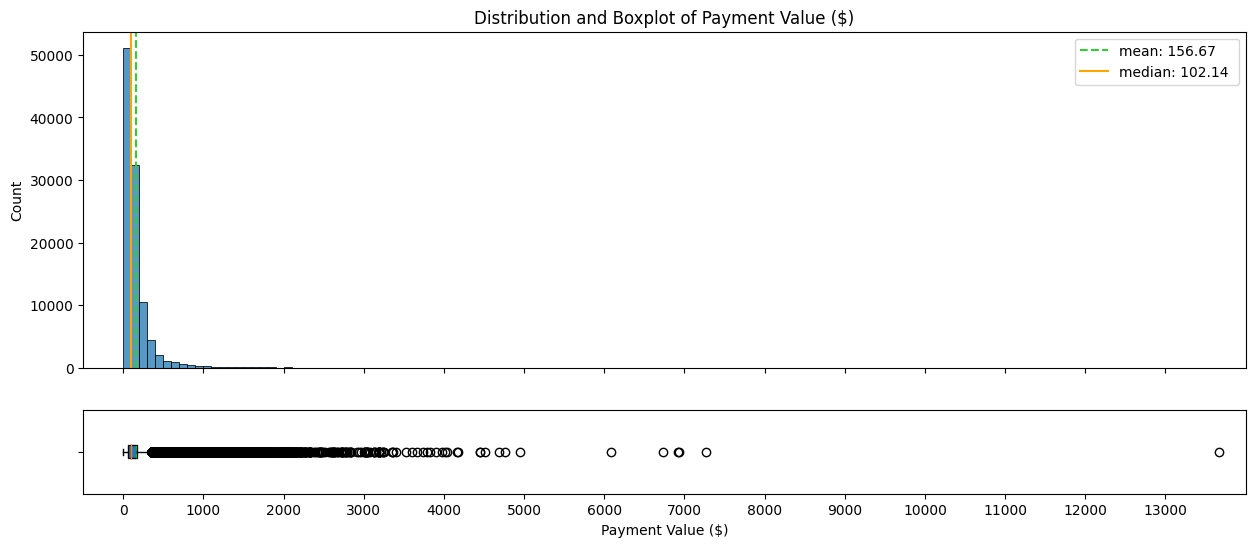

In [42]:
distboxplot(data=master_data[master_data["order_status"]=="delivered"], column="payment_value", bins=np.arange(0,14000,100),
            xticks=np.arange(0,14000,1000), xlim=[-500,14000], xlabel="Payment Value ($)", unit="",
            title="Distribution and Boxplot of Payment Value ($)", figsize=(15,6))

In [43]:
master_data[master_data["payment_value"]>5000][["customer_unique_id", "order_id", "product_id", "order_item_count", "price", "payment_value"]]

,customer_unique_id,order_id,product_id,order_item_count,price,payment_value
2199,dc4802a71eae9be1dd28f5d788ceb526,0812eb902a67711a1cb742b3cdaa65ae,489ae2aa008f021502940f251d4cce7f,1.0,6735.0,6929.31
11969,ff4159b92c40ebe40454e3e6a7c35ed6,f5136e38d1a14a4dbd87dff67da82701,1bdf5e6731585cf01aa8169c7028d6ad,1.0,6499.0,6726.66
30164,0a0a92112bd4c708ca5fde585afaa872,03caa2c082116e1d31e67e9ae3700499,5769ef0a239114ac3a854af00df129e4,8.0,1680.0,13664.08
40194,4007669dec559734d6f53e029e360987,2cc9089445046817a7539d90805e6e5a,c183fd5d2abf05873fa6e1014ed9e06c,6.0,989.1,6081.54
96545,763c8b1c9c68a0229c42c9fc6f662b93,736e1922ae60d0d6a89247b851902527,19936fa4f614ee0590d3b77ac83fd648,4.0,1790.0,7274.88
99241,459bef486812aa25204be022145caa62,fefacc66af859508bf1a7934eab1e97f,69c590f7ffc7bf8db97190b6cb6ed62e,1.0,6729.0,6922.21


Ada dua kemungkinan penyebab outlier pada payment_value yaitu: base price produk sudah tinggi atau customer membeli produk dalam jumlah besar. Dengan kata lain, outlier terjadi bukan karena kesalahan input atau kondisi tidak masuk akal melainkan karena ada kondisi riil yang memang dapat menyebabkan adanya outlier tersebut, sehingga outlier akan dibiarkan apa adanya.

### **1.2.7 Save Data**

Data sudah siap digunakan untuk proses selanjutnya.

In [44]:
master_data.to_csv("../data/processed/master_data.csv", index=False)